# Running `pw.x` in AiiDA


## Basic Quantum Espresso Example

As a first example, lets take a look at how to run a simple calculation using the `pw.x` code from the [Quantum ESPRESSO](https://www.quantum-espresso.org/) package.

Running without AiiDA, we could use the following input file:

In [105]:
!cat direct_run/aiida.in

&CONTROL
  calculation = 'relax'
  etot_conv_thr =   2.0000000000d-04
  forc_conv_thr =   1.0000000000d-03
  max_seconds =   86400
  outdir = './out/'
  prefix = 'aiida'
  pseudo_dir = './pseudo/'
  restart_mode = 'from_scratch'
  tprnfor = .true.
  tstress = .true.
  verbosity = 'high'
/
&SYSTEM
  degauss =   1.0000000000d-02
  ecutrho =   2.4000000000d+02
  ecutwfc =   3.0000000000d+01
  ibrav = 0
  nat = 2
  nosym = .false.
  ntyp = 1
  occupations = 'smearing'
  smearing = 'cold'
/
&ELECTRONS
  conv_thr =   8.0000000000d-10
  electron_maxstep = 80
  mixing_beta =   4.0000000000d-01
/
&IONS
/
ATOMIC_SPECIES
Si     28.085 Si.pbe-n-rrkjus_psl.1.0.0.UPF
ATOMIC_POSITIONS angstrom
Si           0.0000000000       0.0000000000       0.0000000000 
Si           1.8940738226       1.0935440313       0.7732524001 
K_POINTS automatic
5 5 5 0 0 0
CELL_PARAMETERS angstrom
      3.7881476452       0.0000000000       0.0000000000
      1.8940738226       3.2806320940       0.0000000000
      1.8940

We could then run the calculation, on the available CPU cores.

In [1]:
import psutil
cpu_count = psutil.cpu_count(logical=False)
cpu_count

4

In [10]:
!mkdir -p direct_run/out
!rm -rf direct_run/out/*
!cd direct_run && mpirun -np {min(cpu_count, 2)} pw.x -in aiida.in > out/aiida.out

Note: The following floating-point exceptions are signalling: IEEE_DENORMAL
Note: The following floating-point exceptions are signalling: IEEE_DENORMAL


We now have access to the text based and XML output files, which we can parse to extract the relevant results.

In [106]:
!ls direct_run/out

aiida.out  aiida.save aiida.xml


In [61]:
!tail -n 5 direct_run/out/aiida.out

   This run was terminated on:  21:58:59  20Sep2022            

=------------------------------------------------------------------------------=
   JOB DONE.
=------------------------------------------------------------------------------=


In [122]:
from pathlib import Path
import xmltodict

xml_output = xmltodict.parse(Path("direct_run/out/aiida.xml").read_bytes())
xml_output["qes:espresso"]["output"]["convergence_info"]


{'scf_conv': {'convergence_achieved': 'true',
  'n_scf_steps': '8',
  'scf_error': '2.047382223968647e-10'},
 'opt_conv': {'convergence_achieved': 'true',
  'n_opt_steps': '0',
  'grad_norm': '1.213624545212296e-6'}}

This is a very simple example, that one could run without any automation.
However, as the number of calculations increases, and the complexity of the input files, it becomes increasingly difficult to keep track of the calculations, and to reproduce them:

:::{admonition} What about complex computations?

- What if we want to run more than one computation?
- What if we want to chain this computation to others?
- What if things go wrong?
- How do we work with a HPC cluster?

:::


## Implementing in AiiDA


With AiiDA, we want to split the input generation into separate *nodes*, handling the different aspects of the calculation and allow for component re-use.
For a `pw.x` calculation, we would need to create the following nodes:

- `Computer`, which describes how we interface with a compute resource
- `Code`, which contains the information on how to execute a single calculation
- `StructureData`, which contains the crystal structure
- `UpfData`, which contains the pseudo-potentials per atomic
- `KpointsData`, which contains the k-point mesh
- `Dict` node, which contains the parameters for the calculation

### The AiiDA Profile

First we create a new AiiDA profile.
This is where we store all the nodes generated for a project, and the links between them.

In [1]:
import os
os.environ["AIIDA_PATH"] = os.path.abspath("_aiida_config")
from aiida import engine, load_profile, orm, plugins
from aiida.storage.sqlite_temp import SqliteTempBackend
%load_ext aiida

In [2]:
profile = load_profile(
    SqliteTempBackend.create_profile(
        "temp_profile",
        options={"runner.poll.interval": 1},
        debug=False,
    ),
)
profile

Profile<uuid='e77235f44aa34101b393d330a60e460c' name='temp_profile'>

AiiDA can be controlled in two main ways:

1. Using the Python API, which is the most flexible, but requires some programming knowledge. 
2. Using the `verdi` command line interface (CLI), which is more limited, but easier to use.

Below we check the status of our loaded profile in the CLI:

In [4]:
%verdi status --no-rmq

 ✔ version:     AiiDA v2.0.1
 ✔ config:      /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/_aiida_config/.aiida
 ✔ profile:     temp_profile
 ✔ storage:     SqliteTemp storage [open], sandbox: /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/_aiida_config/.aiida/repository/temp_profile
 ⏺ daemon:      The daemon is not running


:::{note}

Here we generate a temporary, in-memory profile, which will be destroyed when the kernel is restarted.
This is useful for testing, but for a real project, you should create a persistent profile,
using the `verdi quicksetup` command.

:::

We can also check the statistics of the profile.
Before running any simulations, we see that only a single `User` node has been created, which is the default user for the profile.

In [3]:
%verdi storage info

entities:
  Users:
    count: 1
  Computers:
    count: 0
  Nodes:
    count: 0
  Groups:
    count: 0
  Comments:
    count: 0
  Logs:
    count: 0
  Links:
    count: 0



### Connecting to a compute resource

An AiiDA `Computer` node represents a compute resource, such as a local or remote machine.
It contains information on how to connect to the machine, how to **transport** data to/from the compute resource, and how to **schedule** jobs on it.

In the following we will use a simple `local_direct` computer, which connects to the local machine, and runs the calculations directly, without any scheduler.

AiiDA also has built-in support for a number of schedulers, including:

- `pbspro`
- `slurm`
- `sge`
- `torque`
- `lsf`

Connections to remote machines can be made using `SSH`, and [aiida-code-registry](https://github.com/aiidateam/aiida-code-registry) provides a collection of example configurations for Swiss based HPC clusters.

In [4]:
created, computer = orm.Computer.collection.get_or_create(
    label="local_direct",
    description="local computer with direct scheduler",
    hostname="localhost",
    workdir=os.path.abspath("_aiida_workdir"),
    transport_type="core.local",
    scheduler_type="core.direct",
)
if created:
    computer.store()
    computer.set_minimum_job_poll_interval(0.0)
    computer.set_default_mpiprocs_per_machine(min(cpu_count, 2))
    computer.configure()
computer

<Computer: local_direct (localhost), pk: 1>

In [5]:
%verdi computer show local_direct

---------------------------  --------------------------------------------------------------------------
Label                        local_direct
PK                           1
UUID                         6d393fdd-ae2f-4079-a6ca-92d02e11d49b
Description                  local computer with direct scheduler
Hostname                     localhost
Transport type               core.local
Scheduler type               core.direct
Work directory               /Users/chrisjsewell/Documents/GitHub/aiida-qe-demo/tutorial/_aiida_workdir
Shebang                      #!/bin/bash
Mpirun command               mpirun -np {tot_num_mpiprocs}
Default #procs/machine       2
Default memory (kB)/machine
Prepend text
Append text
---------------------------  --------------------------------------------------------------------------


### Setting up a code plugin

AiiDA `Code` nodes represent a single executable, and contain information on how to execute it.
The `Code` node is associated with a specific `Computer` node, contains the path to the executable, and is associated with a specific *plugin*.

The plugin is a Python module that contains the instructions on how to run a calculation.

In [6]:
import shutil
try:
    code = orm.load_code("pw.x@local_direct")
except:
    code = orm.Code(
        input_plugin_name="quantumespresso.pw",
        remote_computer_exec=[computer, shutil.which("pw.x")],
    )
    code.label = "pw.x"
    code.description = "Quantum ESPRESSO pw.x code"
    code.set_prepend_text("export OMP_NUM_THREADS=1")
    code.store()
code

<Code: Remote code 'pw.x' on local_direct, pk: 1, uuid: 3653ca13-50e7-4e3e-8d42-acee2d662e17>

In [10]:
%verdi code show pw.x

--------------------  --------------------------------------------------------------
PK                    1
UUID                  3653ca13-50e7-4e3e-8d42-acee2d662e17
Label                 pw.x
Description           Quantum ESPRESSO pw.x code
Default plugin        quantumespresso.pw
Type                  remote
Remote machine        local_direct
Remote absolute path  /Users/chrisjsewell/opt/miniconda3/envs/aiida-qe-demo/bin/pw.x
Prepend text          export OMP_NUM_THREADS=1
Append text
--------------------  --------------------------------------------------------------


### Generating the configuration for a computation 

Once we have a `Code` stored in our profile, we can load it to generate a *builder* of inputs for the calculation.

In [11]:
code = orm.load_code("pw.x@local_direct")
builder = code.get_builder()
builder

Process class: PwCalculation
Inputs:
code: Quantum ESPRESSO pw.x code
metadata:
  options:
    stash: {}
pseudos: {}


The builder provides us a structured way to add (and validate) the inputs for the calculation.
Below we convert the input for our original calculations into the nodes that we need for the AiiDA calculation.

In [12]:
import qe_tools
pw_input = qe_tools.parsers.PwInputFile(open("direct_run/aiida.in").read())

builder.structure = orm.StructureData(cell=pw_input.structure["cell"])
for p, s in zip(pw_input.structure["positions"], pw_input.structure["atom_names"]):
    builder.structure.append_atom(position=p, symbols=s)

parameters = pw_input.namelists
for disallowed in ["pseudo_dir", "outdir", "prefix"]:
    parameters["CONTROL"].pop(disallowed, None)
for disallowed in ["nat", "ntyp"]:
    parameters["SYSTEM"].pop(disallowed, None)
builder.parameters = orm.Dict(dict=parameters)

builder.kpoints = orm.KpointsData()
builder.kpoints.set_cell_from_structure(builder.structure)
builder.kpoints.set_kpoints_mesh(
    pw_input.k_points["points"],
    offset=pw_input.k_points["offset"],
)

builder.pseudos = {
    "Si": orm.UpfData.get_or_create(
        os.path.abspath("direct_run/pseudo/Si.pbe-n-rrkjus_psl.1.0.0.UPF")
    )[0]
}

builder

Process class: PwCalculation
Inputs:
code: Quantum ESPRESSO pw.x code
kpoints: 'Kpoints mesh: 5x5x5 (+0.0,0.0,0.0)'
metadata:
  options:
    stash: {}
parameters:
  CONTROL:
    calculation: relax
    etot_conv_thr: 0.0002
    forc_conv_thr: 0.001
    max_seconds: 86400
    restart_mode: from_scratch
    tprnfor: true
    tstress: true
    verbosity: high
  ELECTRONS:
    conv_thr: 8.0e-10
    electron_maxstep: 80
    mixing_beta: 0.4
  SYSTEM:
    degauss: 0.01
    ecutrho: 240.0
    ecutwfc: 30.0
    ibrav: 0
    nosym: false
    occupations: smearing
    smearing: cold
pseudos:
  Si: ''
structure: Si


### Running a calculation

AiiDA provides two main ways to run a calculation:

1. Using the `engine.run` functions, which runs the computation directly and waits for it to complete.
2. Using the `engine.submit` function, which submits the calculation to the AiiDA daemon, which can be started in the background and manages the execution of the calculations.

In [14]:
output = engine.run_get_node(builder)
output.node

<CalcJobNode: uuid: fe74be22-4dfc-4568-9548-c79e4b90be2a (pk: 13) (aiida.calculations:quantumespresso.pw)>

### Visualising a calculation

We can monitor the status of a computation using using the `verdi process` command.

In [15]:
%verdi process list -a

  PK  Created    Process label    Process State    Process status
----  ---------  ---------------  ---------------  ----------------
   6  4m ago     PwCalculation    ⏹ Finished [0]
  13  3m ago     PwCalculation    ⏹ Finished [0]

Total results: 2

Report: last time an entry changed state: 3m ago (at 11:41:23 on 2022-09-21)


Once the calculation has completed, the `Graph` tool can be used to visualise the provenance graph of the calculation.
The provence graph is a directed acyclic graph (DAG) that contains the nodes and links between them.

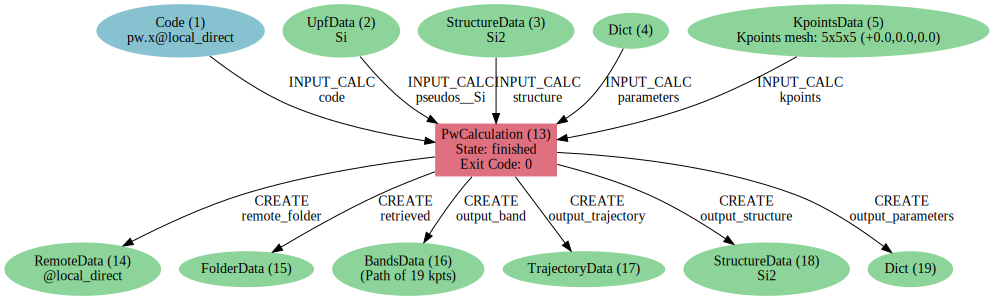

In [16]:
from aiida.tools.visualization import Graph
graph = Graph()
graph.add_incoming(output.node, annotate_links="both")
graph.add_outgoing(output.node, annotate_links="both")
graph.graphviz

### Exporting the results

We can now see that these nodes have all been stored in the AiiDA profile's storage.

In [17]:
%verdi storage info

entities:
  Users:
    count: 1
  Computers:
    count: 1
  Nodes:
    count: 19
  Groups:
    count: 0
  Comments:
    count: 0
  Logs:
    count: 0
  Links:
    count: 22



TODO archiving is not working with the temporary profile 😢

%verdi archive create --all archive.aiida